In [4]:
from transformers import AutoModel, AutoTokenizer

encoder = "../bin/LaBSE-based-Arabic-News-Classifier"
encoder_tokenizer = AutoTokenizer.from_pretrained(encoder)
encoder_model = AutoModel.from_pretrained(encoder)

In [24]:
import pandas as pd
classes = ["life", "politics", "sports", "business"]
valid_df = pd.read_csv("../data/val.csv")
valid_df = valid_df[["text", "section"]]
valid_df = valid_df[valid_df["section"].isin(classes)]
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 127 to 291
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     120 non-null    object
 1   section  120 non-null    object
dtypes: object(2)
memory usage: 2.8+ KB


In [28]:
from tqdm import tqdm
embeddings_lst = []
for idx, row in tqdm(valid_df.iterrows(), desc = "Embed News: "):
    example_tokens = encoder_tokenizer(
        row["text"], return_tensors="pt",
        padding=True,
        truncation=True,
    )
    results = encoder_model(**example_tokens)
    embeddings = results.last_hidden_state[:, 0, :].cpu().detach().numpy()
    embeddings = embeddings.flatten().tolist()
    embeddings_lst.append(embeddings)

Embed News: : 120it [01:40,  1.20it/s]


In [30]:
import numpy as np
embeddings_arr = np.array(embeddings_lst)

In [32]:
emb_df = pd.DataFrame(embeddings_arr)
emb_df.shape

(120, 768)

In [33]:
from sklearn.cluster import DBSCAN
from umap import UMAP

In [34]:
mapper = UMAP(n_components=2, metric="cosine").fit(
    embeddings_arr
)

In [37]:
#### save for later...
with open("../data/valid_embeddings.npy", "wb") as emb:
    np.save(emb, embeddings_arr)

In [40]:
projections= mapper.transform(embeddings_arr)

In [42]:
with open("../data/valid_umap_projections.npy", "wb") as proj:
    np.save(proj, projections)

In [52]:
def set_color(x):
    if x == "politics":
        return "r"
    elif x == "sports":
        return "green"
    elif x == "life":
        return "black"
    elif x == "business":
        return "orange"

In [53]:
import matplotlib.pyplot as plt
def show(df):
    fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
    #df["color"] = df["labels"].apply(lambda x: "C0" if x==-1 else f"C{(x%9)+1}")
    df = pd.DataFrame({
        "X": df[:, 0],
        "Y": df[:, 1],
        "color": valid_df["section"].apply(set_color)
    })
    df.plot(
        kind="scatter",
        x="X",
        y="Y",
        #z="labels",
        s=10.75,
        alpha=0.8,
        linewidth=0,
        color=df["color"],
        ax=ax,
        colorbar=False,
    )
    ax.set_axis_off()

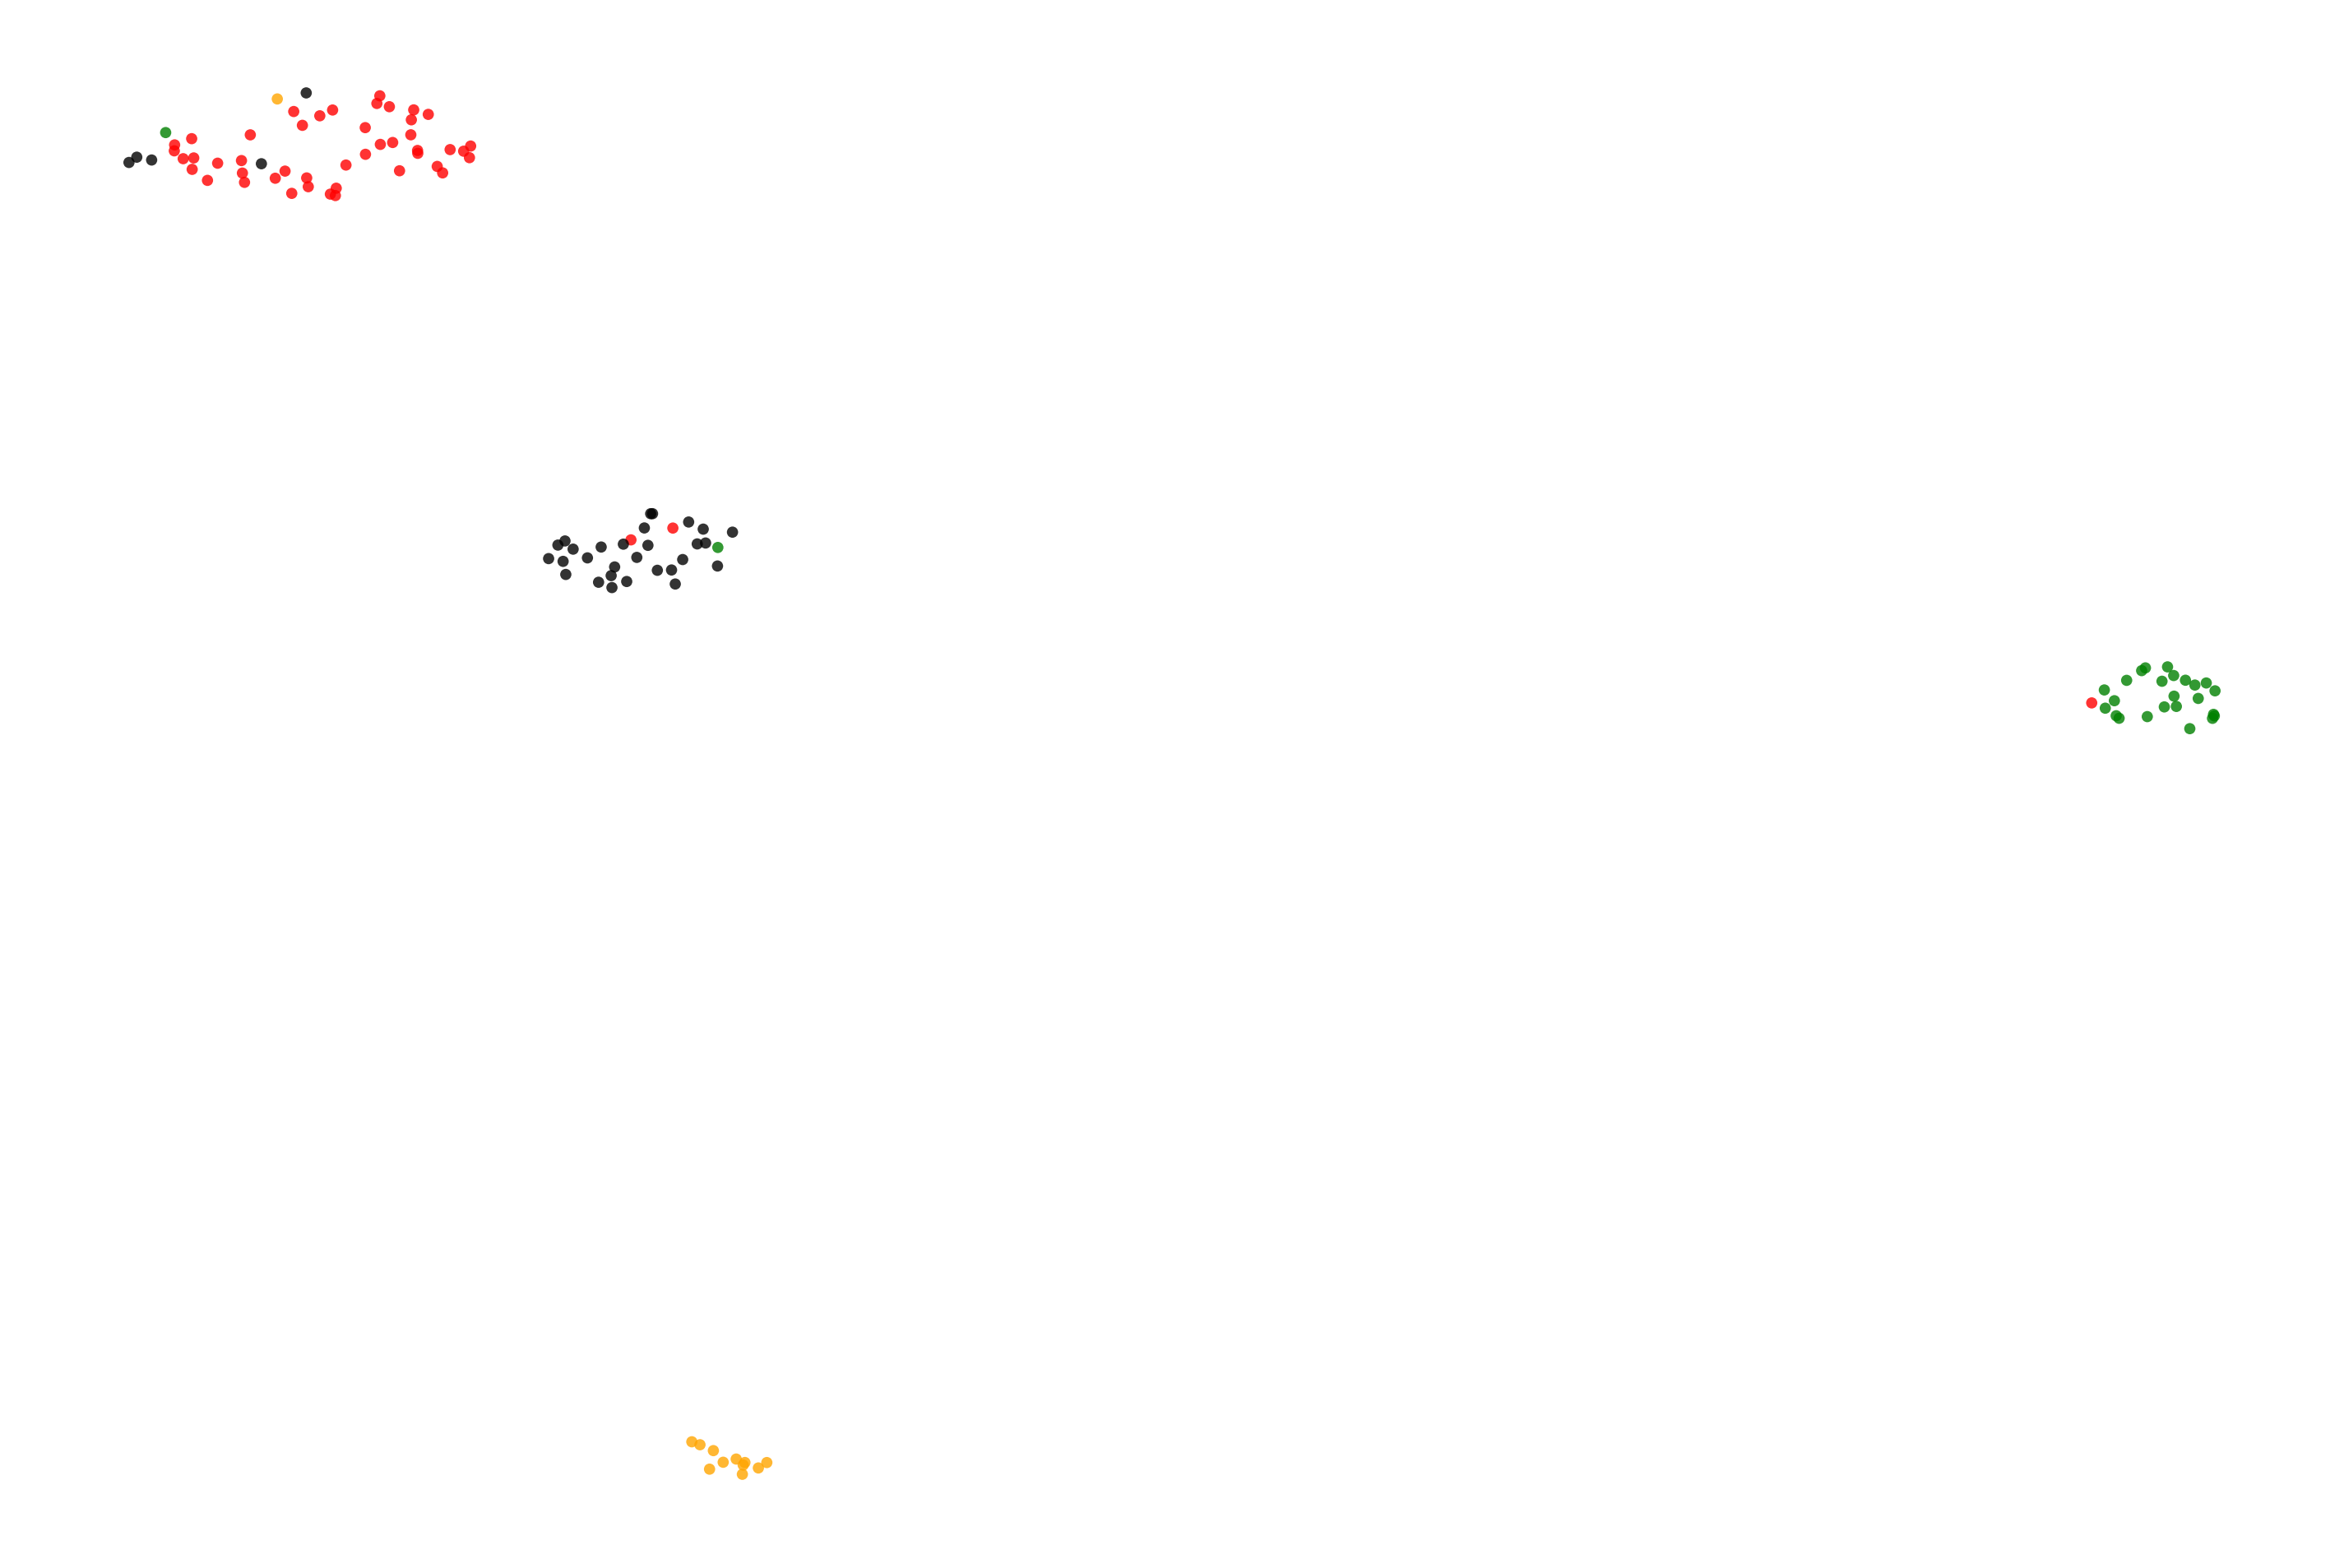

In [54]:
show(projections)